In [4]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image, ImageOps, ImageFilter
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
np.random.seed(123)
import os
from keras.applications import inception_v3
from keras.applications import InceptionResNetV2
from keras.applications import VGG16
from keras.applications import Xception
from keras.applications import ResNet152
import efficientnet.keras as efn
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model
import itertools

### Image Augmentation to handle class imbalance

### Reading Images from train and test folders

In [5]:
train = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = '/floyd/input/chest_xray/train',
        class_mode = 'binary',
        target_size = (128, 128),
        batch_size = 7772) 

Found 7772 images belonging to 2 classes.


In [6]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = '/floyd/input/chest_xray/test',
        class_mode = 'binary',
        target_size = (128, 128),
        batch_size = 624) 

Found 624 images belonging to 2 classes.


### Spliting labels and Images

In [7]:
test_images, test_labels = next(test)
train_images, train_labels = next(train)

In [8]:
test_labels = np.reshape(test_labels, (len(test_labels),1)).astype(int)
train_labels = np.reshape(train_labels, (len(train_labels),1)).astype(int)

### Creating Validation Set

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

## CNN Baseline

In [34]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['acc', tf.metrics.Recall()])

In [35]:
cnn1 = cnn.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(x_val, y_val),
                      workers = -1)

Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 9s 1ms/step - loss: 0.2639 - acc: 0.8723 - recall_3: 0.6925 - val_loss: 0.0791 - val_acc: 0.9743 - val_recall_3: 0.8637
Epoch 2/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0848 - acc: 0.9688 - recall_3: 0.8985 - val_loss: 0.0933 - val_acc: 0.9672 - val_recall_3: 0.9170
Epoch 3/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0842 - acc: 0.9683 - recall_3: 0.9262 - val_loss: 0.0659 - val_acc: 0.9711 - val_recall_3: 0.9342
Epoch 4/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0584 - acc: 0.9793 - recall_3: 0.9407 - val_loss: 0.0748 - val_acc: 0.9691 - val_recall_3: 0.9460
Epoch 5/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0529 - acc: 0.9799 - recall_3: 0.9498 - val_loss: 0.0438 - val_acc: 0.9826 - val_recall_3: 0.9531
Epoch 6/10
6217/6217 [==============================] - 8s 1ms/step - lo

In [36]:
results_train = cnn.evaluate(x_train, y_train)
results_test = cnn.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 0s 602us/step
Train:  [0.004932609713976466, 0.9993566274642944, 0.9729208946228027]
Test:  [1.7193762889275184, 0.7307692170143127, 0.9740020036697388]


In [38]:
# Dictionary to keep track of metrics from all models
scores = {}

In [39]:
scores['CNN'] = [1.7193762889275184, 0.7307692170143127, 0.9740020036697388]

### For Training model

In [10]:
def train_model(model, opt, met, shape, ep):
    """
    model: Model
    opt: Optimizer
    met: Evaluation Metrics
    shape: input shape of Image
    ep: epochs
    """
    mod = model(weights='imagenet',include_top=False, input_shape = shape)
    mod_new = mod.output
    new_model = models.Sequential()
    new_model.add(mod)
    new_model.add(GlobalAveragePooling2D())
    new_model.add(Dense(1024,activation='relu'))
    new_model.add(Dense(1024,activation='relu')) #dense layer 2
    new_model.add(Dense(512,activation='relu')) #dense layer 3
    new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation
    
    new_model.compile(optimizer = opt,loss = 'binary_crossentropy',metrics = met )
    nm = new_model.fit(x_train,
             y_train,
             epochs = ep,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)
    return new_model, nm
    

### Function to plot confusion matrix of model

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Function to predict on one image

In [12]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    if predict > 0.5:
        return 1
    else:
        return 0

### Turning Prediction precentage to class

In [13]:
def prediction(model, images):
    return np.around(model.predict(images))

### Function to plot loss and accuracy with all epochs

In [14]:
def plott(model):
    hist_cnn = model.history
    loss_values = hist_cnn['loss']
    val_loss_values = hist_cnn['val_loss']
    acc_values = hist_cnn['accuracy'] 
    val_acc_values = hist_cnn['val_accuracy']
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'g.', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc_values, 'r.', label='Training acc')
    plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## InceptionV3

In [20]:
mod, plot = train_model(inception_v3.InceptionV3, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 15)

87916544/87910968 [==============================] - 4s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/15
6217/6217 [==============================] - 92s 15ms/step - loss: 0.3126 - accuracy: 0.8720 - recall_1: 0.7265 - val_loss: 0.1437 - val_accuracy: 0.9383 - val_recall_1: 0.8365
Epoch 2/15
6217/6217 [==============================] - 59s 10ms/step - loss: 0.0674 - accuracy: 0.9759 - recall_1: 0.8743 - val_loss: 0.0626 - val_accuracy: 0.9743 - val_recall_1: 0.9007
Epoch 3/15
6217/6217 [==============================] - 60s 10ms/step - loss: 0.0381 - accuracy: 0.9863 - recall_1: 0.9150 - val_loss: 0.0278 - val_accuracy: 0.9904 - val_recall_1: 0.9280
Epoch 4/15
6217/6217 [==============================] - 60s 10ms/step - loss: 0.0184 - accuracy: 0.9942 - recall_1: 0.9372 - val_loss: 0.0250 - val_accuracy: 0.9910 - val_recall_1: 0.9444
Epoch 5/15
6217/6217 [==============================] - 59s 10ms/step - loss: 0.0085 - accuracy: 0.9979 - recall_1: 0.9500 - val_loss: 

In [22]:
results_train = mod.evaluate(x_train, y_train)
results_test = mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 2s 4ms/step
Train:  [0.00024959550582067243, 1.0, 0.9837090969085693]
Test:  [0.950738454476381, 0.8413461446762085, 0.9841669201850891]


In [40]:
scores['InceptionV3'] = [0.950738454476381, 0.8413461446762085, 0.9841669201850891]

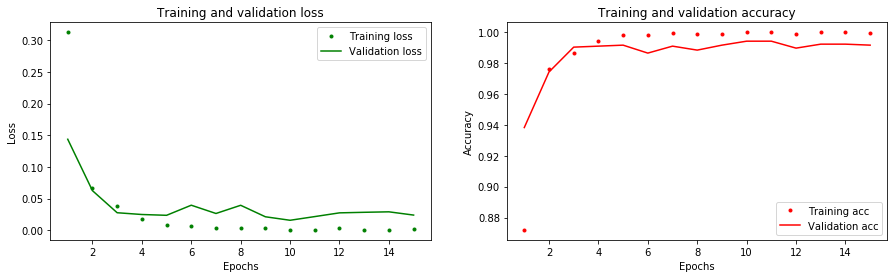

In [23]:
plott(plot)

In [24]:
pred = prediction(mod, test_images)

Confusion matrix, without normalization
[[137  97]
 [  2 388]]


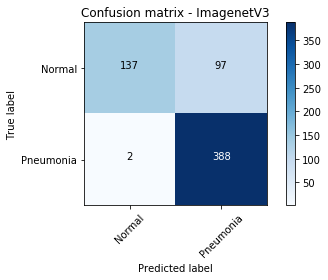

In [25]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

## VGG 16

In [60]:
vgg_mod, vgg_plot = train_model(VGG16, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

58892288/58889256 [==============================] - 3s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 72s 12ms/step - loss: 0.3925 - accuracy: 0.8194 - recall_10: 0.6549 - val_loss: 0.2437 - val_accuracy: 0.9093 - val_recall_10: 0.8219
Epoch 2/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.1355 - accuracy: 0.9516 - recall_10: 0.8682 - val_loss: 0.0600 - val_accuracy: 0.9807 - val_recall_10: 0.8934
Epoch 3/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.0681 - accuracy: 0.9747 - recall_10: 0.9088 - val_loss: 0.0588 - val_accuracy: 0.9788 - val_recall_10: 0.9213
Epoch 4/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.0571 - accuracy: 0.9789 - recall_10: 0.9295 - val_loss: 0.3388 - val_accuracy: 0.8727 - val_recall_10: 0.9297
Epoch 5/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.0500 - accuracy: 0.9831 - recall_10: 0.9300 - v

In [61]:
results_train = vgg_mod.evaluate(x_train, y_train)
results_test = vgg_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 3s 4ms/step
Train:  [0.03964818266018307, 0.9861669540405273, 0.9617879986763]
Test:  [0.9210930481935159, 0.7403846383094788, 0.9633430242538452]


In [41]:
scores['VGG16'] = [0.9210930481935159, 0.7403846383094788, 0.9633430242538452]

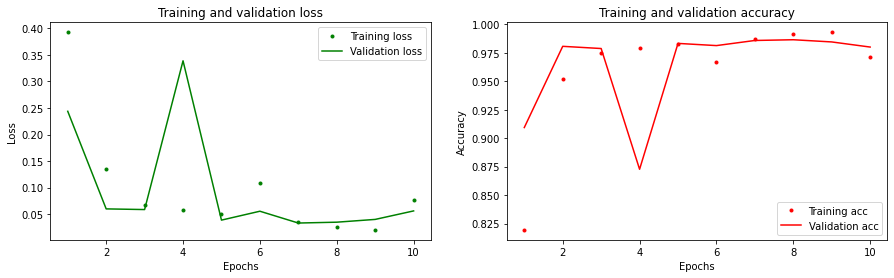

In [62]:
plott(vgg_plot)

In [66]:
vgg_pred = prediction(vgg_mod, test_images)

Confusion matrix, without normalization
[[ 72 162]
 [  0 390]]


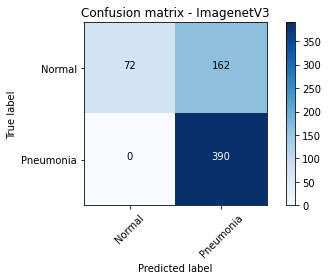

In [67]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, vgg_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

## EfficientNetB4

In [74]:
ef_mod, ef_plot = train_model(efn.EfficientNetB4, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

71892992/71892840 [==============================] - 3s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 193s 31ms/step - loss: 0.6477 - accuracy: 0.7028 - recall_11: 0.5061 - val_loss: 0.6392 - val_accuracy: 0.7151 - val_recall_11: 0.7097
Epoch 2/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.4307 - accuracy: 0.8953 - recall_11: 0.7694 - val_loss: 0.4370 - val_accuracy: 0.8412 - val_recall_11: 0.8100
Epoch 3/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.2008 - accuracy: 0.9418 - recall_11: 0.8354 - val_loss: 0.3044 - val_accuracy: 0.8765 - val_recall_11: 0.8549
Epoch 4/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.1351 - accuracy: 0.9538 - recall_11: 0.8685 - val_loss: 0.2427 - val_accuracy: 0.9003 - val_recall_11: 0.8799
Epoch 5/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.1096 - accuracy: 0.9628 - recall_11: 0.889

In [75]:
results_train = ef_mod.evaluate(x_train, y_train)
results_test = ef_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 4s 6ms/step
Train:  [0.02610859258505756, 0.9937268495559692, 0.9402823448181152]
Test:  [0.8752664648569547, 0.7676281929016113, 0.9426762461662292]


In [42]:
scores['EfficientNetB4'] = [0.8752664648569547, 0.7676281929016113, 0.9426762461662292]

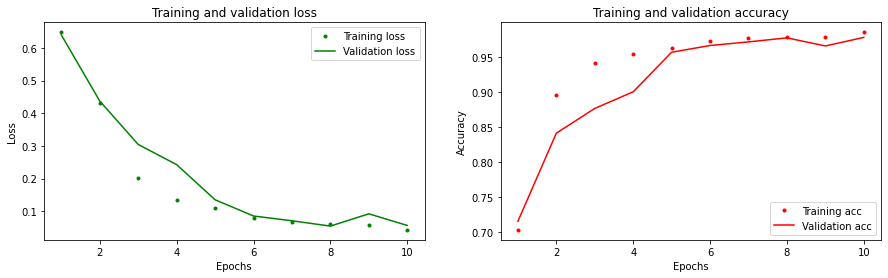

In [76]:
plott(ef_plot)

In [77]:
ef_pred = prediction(ef_mod, test_images)

Confusion matrix, without normalization
[[ 90 144]
 [  1 389]]


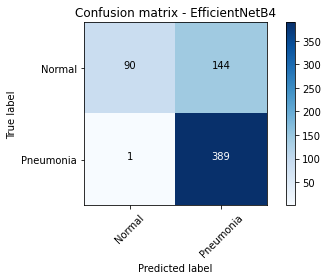

In [80]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, ef_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - EfficientNetB4')

## EfficientNetB1

In [29]:
ef1_mod, ef1_plot = train_model(efn.EfficientNetB1, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

27164672/27164032 [==============================] - 1s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 118s 19ms/step - loss: 0.5633 - accuracy: 0.7970 - recall_2: 0.7726 - val_loss: 0.4912 - val_accuracy: 0.9023 - val_recall_2: 0.8250
Epoch 2/10
6217/6217 [==============================] - 82s 13ms/step - loss: 0.2450 - accuracy: 0.9279 - recall_2: 0.8536 - val_loss: 0.3176 - val_accuracy: 0.9113 - val_recall_2: 0.8768
Epoch 3/10
6217/6217 [==============================] - 83s 13ms/step - loss: 0.1436 - accuracy: 0.9511 - recall_2: 0.8901 - val_loss: 0.3318 - val_accuracy: 0.8540 - val_recall_2: 0.9018
Epoch 4/10
6217/6217 [==============================] - 83s 13ms/step - loss: 0.0969 - accuracy: 0.9673 - recall_2: 0.9114 - val_loss: 0.1465 - val_accuracy: 0.9492 - val_recall_2: 0.9190
Epoch 5/10
6217/6217 [==============================] - 83s 13ms/step - loss: 0.0736 - accuracy: 0.9756 - recall_2: 0.9249 - val_loss:

In [30]:
results_train = ef1_mod.evaluate(x_train, y_train)
results_test = ef1_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 2s 4ms/step
Train:  [0.011878194365166853, 0.9983915090560913, 0.9594538807868958]
Test:  [0.6039071480433146, 0.8253205418586731, 0.9610865712165833]


In [43]:
scores['EfficientNetB1'] = [0.6039071480433146, 0.8253205418586731, 0.9610865712165833]

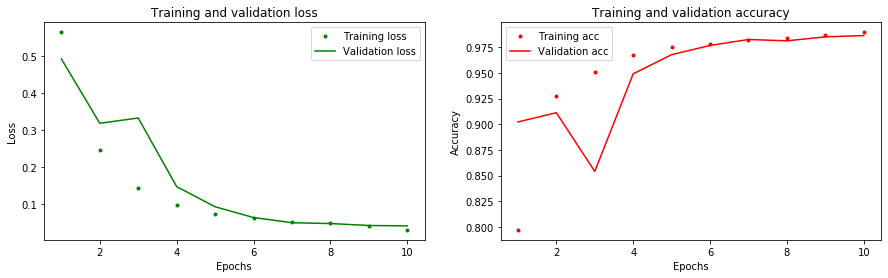

In [31]:
plott(ef1_plot)

In [32]:
ef1_pred = prediction(ef1_mod, test_images)

Confusion matrix, without normalization
[[128 106]
 [  3 387]]


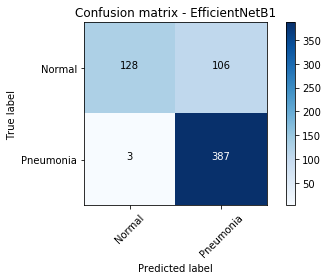

In [33]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, ef1_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - EfficientNetB1')

## ResNet152

In [15]:
rn_mod, rn_plot = train_model(ResNet152, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

234700800/234698864 [==============================] - 10s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 366s 59ms/step - loss: 0.2003 - accuracy: 0.9324 - recall: 0.8459 - val_loss: 18.5176 - val_accuracy: 0.4830 - val_recall: 0.8198
Epoch 2/10
6217/6217 [==============================] - 220s 35ms/step - loss: 0.0404 - accuracy: 0.9873 - recall: 0.8028 - val_loss: 65.6139 - val_accuracy: 0.4830 - val_recall: 0.7981
Epoch 3/10
6217/6217 [==============================] - 220s 35ms/step - loss: 0.0115 - accuracy: 0.9982 - recall: 0.7972 - val_loss: 168.8940 - val_accuracy: 0.4830 - val_recall: 0.7957
Epoch 4/10
6217/6217 [==============================] - 221s 35ms/step - loss: 0.0069 - accuracy: 0.9982 - recall: 0.7959 - val_loss: 219.2359 - val_accuracy: 0.4830 - val_recall: 0.7946
Epoch 5/10
6217/6217 [==============================] - 220s 35ms/step - loss: 0.0065 - accuracy: 0.9982 - recall: 0.7951 - val_loss: 142.

In [16]:
results_train = rn_mod.evaluate(x_train, y_train)
results_test = rn_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 7s 11ms/step
Train:  [0.14359817546845507, 0.9732990264892578, 0.8737955093383789]
Test:  [1.7053394317626953, 0.7259615659713745, 0.878918468952179]


In [44]:
scores['ResNet152'] = [1.7053394317626953, 0.7259615659713745, 0.878918468952179]

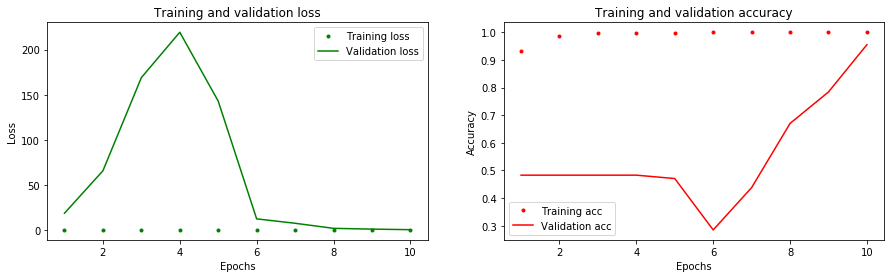

In [17]:
plott(rn_plot)

In [18]:
rn_pred = prediction(rn_mod, test_images)

Confusion matrix, without normalization
[[ 63 171]
 [  0 390]]


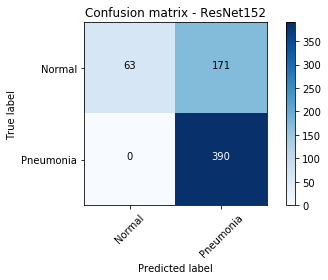

In [19]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, rn_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ResNet152')

## InceptionResNetV2